# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

# Opening file

In [2]:
file_path = './data/synthetic_data_lung_cancer.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())
print(df['DEFINITION_ID'].unique())

   SUBJECT_ID    DEFINITION_ID      TIME
0           1         drug_217  0.004807
1           1   condition_1922  0.008643
2           1    condition_785  0.027792
3           1          drug_49  0.032515
4           1  measurement_132  0.056765
['drug_217' 'condition_1922' 'condition_785' ... 'condition_842'
 'condition_1204' 'condition_807']


# Data exploration

In [3]:
# Display basic information about the dataset
print("Dataset Overview:")
print(df.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Display the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(df.head())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560971 entries, 0 to 560970
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SUBJECT_ID     560971 non-null  int64  
 1   DEFINITION_ID  560971 non-null  object 
 2   TIME           560971 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.8+ MB
None

Summary Statistics:
          SUBJECT_ID           TIME
count  560971.000000  560971.000000
mean      478.783759       4.160220
std       274.017435       2.372683
min         1.000000       0.000001
25%       242.000000       2.166878
50%       471.000000       4.220659
75%       701.000000       6.159830
max       984.000000      16.866712

First Few Rows:
   SUBJECT_ID    DEFINITION_ID      TIME
0           1         drug_217  0.004807
1           1   condition_1922  0.008643
2           1    condition_785  0.027792
3           1          drug_49  0.032515
4           

In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicate entries
duplicate_entries = df[df.duplicated()]
print("\nDuplicate Entries:")
print(duplicate_entries)


Missing Values:
SUBJECT_ID       0
DEFINITION_ID    0
TIME             0
dtype: int64

Duplicate Entries:
Empty DataFrame
Columns: [SUBJECT_ID, DEFINITION_ID, TIME]
Index: []


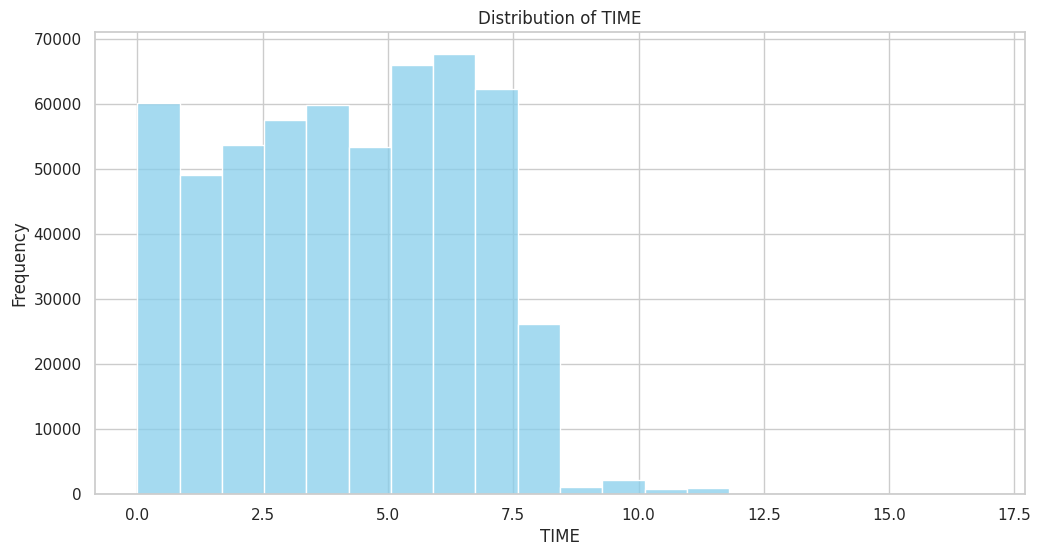

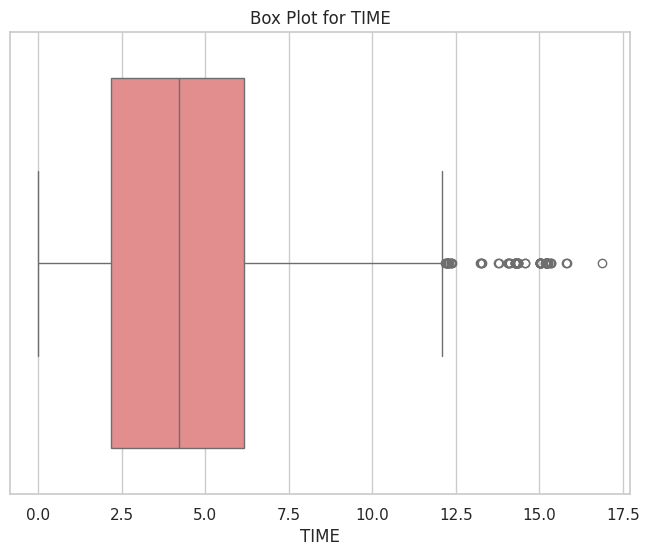

In [5]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plotting the distribution of 'TIME' using a histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['TIME'], bins=20, kde=False, color='skyblue')
plt.title('Distribution of TIME')
plt.xlabel('TIME')
plt.ylabel('Frequency')
plt.show()

# Plotting a box plot for 'TIME'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['TIME'], color='lightcoral')
plt.title('Box Plot for TIME')
plt.xlabel('TIME')
plt.show()

# Calculating 1 year mortality

In [6]:
print(df[df['DEFINITION_ID'] == 'death'])

        SUBJECT_ID DEFINITION_ID      TIME
938              2         death  2.518113
2365             4         death  4.002734
4812            10         death  3.969925
5041            12         death  4.267943
5049            15         death  1.192071
...            ...           ...       ...
549038         947         death  2.594668
553175         955         death  2.578264
556881         961         death  1.014354
560197         968         death  2.425154
560907         981         death  3.149692

[263 rows x 3 columns]


In [7]:
# Assuming df is your original DataFrame
df['TIME'] = pd.to_numeric(df['TIME'], errors='coerce')  # Ensure 'TIME' is numeric

# Identify rows where the "death" state is present
death_rows = df[df['DEFINITION_ID'].str.lower() == 'death']

df['DIED'] = 0 

# Iterate through each death row and update DIED column for corresponding rows
for _, death_row in death_rows.iterrows():
    patient_id = death_row['SUBJECT_ID']
    death_time = death_row['TIME']
    
    if death_time < 5:
        # Update DIED to 1 for rows with the same PATIENT_ID and TIME within 1 year
        df.loc[(df['SUBJECT_ID'] == patient_id), 'DIED'] = 1

# Print the updated DataFrame
print(df)

        SUBJECT_ID     DEFINITION_ID      TIME  DIED
0                1          drug_217  0.004807     0
1                1    condition_1922  0.008643     0
2                1     condition_785  0.027792     0
3                1           drug_49  0.032515     0
4                1   measurement_132  0.056765     0
...            ...               ...       ...   ...
560966         984  measurement_1141  0.027321     0
560967         984   observation_156  0.028739     0
560968         984  measurement_1140  0.030802     0
560969         984  measurement_1327  0.035081     0
560970         984     condition_459  0.038022     0

[560971 rows x 4 columns]


In [8]:
print(df[(df['DEFINITION_ID'] == 'death') & (df['TIME'] < 5.0)])

        SUBJECT_ID DEFINITION_ID      TIME  DIED
938              2         death  2.518113     1
2365             4         death  4.002734     1
4812            10         death  3.969925     1
5041            12         death  4.267943     1
5049            15         death  1.192071     1
...            ...           ...       ...   ...
549038         947         death  2.594668     1
553175         955         death  2.578264     1
556881         961         death  1.014354     1
560197         968         death  2.425154     1
560907         981         death  3.149692     1

[168 rows x 4 columns]


In [9]:
print(df[df['SUBJECT_ID'] == 4])

      SUBJECT_ID     DEFINITION_ID      TIME  DIED
1867           4      procedure_25  0.000098     1
1868           4   measurement_447  0.000124     1
1869           4  measurement_1070  0.000295     1
1870           4  measurement_1017  0.000723     1
1871           4   measurement_144  0.000764     1
...          ...               ...       ...   ...
2361           4   measurement_189  2.996606     1
2362           4   measurement_936  2.996828     1
2363           4   measurement_495  2.997869     1
2364           4   measurement_712  3.000096     1
2365           4             death  4.002734     1

[499 rows x 4 columns]


In [10]:
df = df[df['DEFINITION_ID'].str.lower() != 'death']

# One-Hot encoding and removing time
Time will be accounted in subsequence analysis.  

In [11]:
df= df.drop(['TIME'], axis=1)

In [12]:
# One-hot encode the original DataFrame
df = pd.get_dummies(df, columns=['DEFINITION_ID'], prefix='DEF')

# Group by 'SUBJECT_ID' and perform a logical OR on 'DIED'
df_grouped = df.groupby('SUBJECT_ID').max()

# Print the filtered and grouped DataFrame
df_grouped.head()

,DIED,DEF_condition_1,DEF_condition_10,DEF_condition_100,DEF_condition_1000,DEF_condition_1001,DEF_condition_1002,DEF_condition_1003,DEF_condition_1004,DEF_condition_1005,...,DEF_procedure_90,DEF_procedure_91,DEF_procedure_92,DEF_procedure_93,DEF_procedure_94,DEF_procedure_95,DEF_procedure_96,DEF_procedure_97,DEF_procedure_98,DEF_procedure_99
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
1,0,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,False,False,False,False,False,False,False,True,False,...,True,False,True,False,False,False,False,False,False,False
4,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Feature selection : PCA

In [13]:
# Separate features and target variable
X = df_grouped.drop(['DIED'], axis=1)
y = df_grouped['DIED']

# Standardize the features (important for PCA)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Apply PCA
num_components = min(X.shape[0], X.shape[1])  # Choose the number of components
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_standardized)

# Print the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
# print("Explained Variance Ratio:")
# print(explained_variance_ratio)

# Select the desired number of components based on the explained variance
desired_num_components = 40  # Change this as needed
selected_components = X_pca[:, :desired_num_components]

# Create a DataFrame with the selected components and target variable
pca_selected = pd.DataFrame(selected_components, columns=[f'PC{i+1}' for i in range(desired_num_components)])
pca_selected['DIED'] = y.values

# Print the DataFrame with selected components
# print(pca_selected.head())

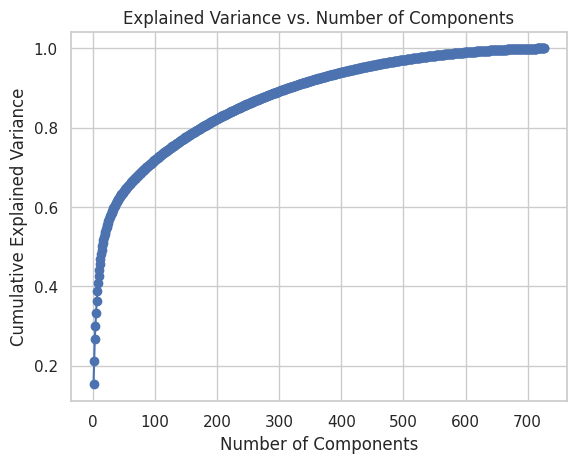

In [14]:
# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Train a model on our data

In [15]:
# Separate features and target variable
X = pca_selected.drop(['DIED'], axis=1)
y = pca_selected['DIED']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
model = LogisticRegression(penalty='l2', C=1.0)
# model.fit(X_train, y_train)
model.fit(X_train, y_train)

# Make predictions on the test set
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test)

# y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class for AUC-ROC
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_result)
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86       122
           1       0.38      0.54      0.45        24

    accuracy                           0.78       146
   macro avg       0.64      0.68      0.66       146
weighted avg       0.82      0.78      0.80       146

AUC-ROC: 0.79


In [16]:
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')

print(f"Cross-Validation Scores: {cross_val_scores}")

Cross-Validation Scores: [0.79805672 0.7710084  0.79924242 0.86498918 0.84048755]
